# Modeling and Simulation in Python

Case study.

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Unrolling

Let's simulate a kitten unrolling toilet paper.  As reference material, see [this video](http://modsimpy.com/kitten).

The interactions of the kitten and the paper roll are complex.  To keep things simple, let's assume that the kitten pulls down on the free end of the roll with constant force.  Also, we will neglect the friction between the roll and the axle.  

![](diagrams/kitten.png)

This figure shows the paper roll with $r$, $F$, and $\tau$.  As a vector quantity, the direction of $\tau$ is into the page, but we only care about its magnitude for now.

We'll start by loading the units we need.

In [2]:
radian = UNITS.radian
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton

<Unit('newton')>

And a few more parameters in the `Params` object.

In [3]:
params = Params(Rmin = 0.02 * m,
                Rmax = 0.055 * m,
                Mcore = 15e-3 * kg,
                Mroll = 215e-3 * kg,
                L = 47 * m,
                tension = 2e-4 * N,
                t_end = 120 * s)

,values
Rmin,0.02 meter
Rmax,0.055 meter
Mcore,0.015 kilogram
Mroll,0.215 kilogram
L,47 meter
tension,0.0002 newton
t_end,120 second


`make_system` computes `rho_h`, which we'll need to compute moment of inertia, and `k`, which we'll use to compute `r`.

In [4]:
def make_system(params):
    """Make a system object.
    
    params: Params with Rmin, Rmax, Mcore, Mroll,
                              L, tension, and t_end
    
    returns: System with init, k, rho_h, Rmin, Rmax,
                         Mcore, Mroll, ts
    """
    L, Rmax, Rmin = params.L, params.Rmax, params.Rmin
    Mroll = params.Mroll
    
    init = State(theta = 0 * radian,
                 omega = 0 * radian/s,
                 y = L)
    
    area = pi * (Rmax**2 - Rmin**2)
    rho_h = Mroll / area
    k = (Rmax**2 - Rmin**2) / 2 / L / radian    
    
    return System(params, init=init, area=area, rho_h=rho_h, k=k)

Testing `make_system`

In [5]:
system = make_system(params)

,values
Rmin,0.02 meter
Rmax,0.055 meter
Mcore,0.015 kilogram
Mroll,0.215 kilogram
L,47 meter
tension,0.0002 newton
t_end,120 second
init,theta 0 radian omega 0.0 radi...
area,0.008246680715673206 meter ** 2
rho_h,26.07109543981524 kilogram / meter ** 2


In [6]:
system.init

,values
theta,0 radian
omega,0.0 radian / second
y,47 meter


Here's how we compute `I` as a function of `r`:

In [7]:
def moment_of_inertia(r, system):
    """Moment of inertia for a roll of toilet paper.
    
    r: current radius of roll in meters
    system: System object with Mcore, rho, Rmin, Rmax
    
    returns: moment of inertia in kg m**2
    """
    Mcore, Rmin, rho_h = system.Mcore, system.Rmin, system.rho_h
    
    Icore = Mcore * Rmin**2   
    Iroll = pi * rho_h / 2 * (r**4 - Rmin**4)
    return Icore + Iroll

When `r` is `Rmin`, `I` is small.

In [8]:
moment_of_inertia(system.Rmin, system)

6e-06 <Unit('kilogram * meter ** 2')>

As `r` increases, so does `I`.

In [9]:
moment_of_inertia(system.Rmax, system)

0.00037418750000000006 <Unit('kilogram * meter ** 2')>

## Exercises

Write a slope function we can use to simulate this system.  Here are some suggestions and hints:

* `r` is no longer part of the `State` object.  Instead, we compute `r` at each time step, based on the current value of `y`, using

$y = \frac{1}{2k} (r^2 - R_{min}^2)$

* Angular velocity, `omega`, is no longer constant.  Instead, we compute torque, `tau`, and angular acceleration, `alpha`, at each time step.

* I changed the definition of `theta` so positive values correspond to clockwise rotation, so `dydt = -r * omega`; that is, positive values of `omega` yield decreasing values of `y`, the amount of paper still on the roll.

* Your slope function should return `omega`, `alpha`, and `dydt`, which are the derivatives of `theta`, `omega`, and `y`, respectively.

* Because `r` changes over time, we have to compute moment of inertia, `I`, at each time step.

That last point might be more of a problem than I have made it seem.  In the same way that $F = m a$ only applies when $m$ is constant, $\tau = I \alpha$ only applies when $I$ is constant.  When $I$ varies, we usually have to use a more general version of Newton's law.  However, I believe that in this example, mass and moment of inertia vary together in a way that makes the simple approach work out.  Not all of my collegues are convinced.

In [10]:
# Solution

def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object with theta, omega, y
    t: time
    system: System object with Rmin, k, Mcore, rho_h, tension
    
    returns: sequence of derivatives
    """
    theta, omega, y = state
    k, Rmin, tension = system.k, system.Rmin, system.tension
    
    r = sqrt(2*k*y + Rmin**2)
    I = moment_of_inertia(r, system)
    tau = r * tension
    alpha = tau / I
    dydt = -r * omega
    
    return omega, alpha, dydt      

Test `slope_func` with the initial conditions.

In [11]:
# Solution

slope_func(system.init, 0*s, system)

(0.0 <Unit('radian / second')>,
 0.02939702689159846 <Unit('newton / kilogram / meter / radian ** 0.5')>,
 -0.0 <Unit('meter * radian ** 0.5 / second')>)

Run the simulation.

In [12]:
# Solution

results, details = run_ode_solver(system, slope_func, max_step=10)
details

,values
sol,None
t_events,[]
nfev,92
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


And look at the results.

In [13]:
results.tail()

,theta,omega,y
83.775812,106.019,2.60318,41.3259
93.775812,133.812,2.95813,39.8903
103.775812,165.241,3.33074,38.293
113.775812,200.498,3.72467,36.5339
120.000000,224.478,3.98256,35.3573


Check the results to see if they seem plausible:

* The final value of `theta` should be about 220 radians.

* The final value of `omega` should be near 4 radians/second, which is less one revolution per second, so that seems plausible.

* The final value of `y` should be about 35 meters of paper left on the roll, which means the kitten pulls off 12 meters in two minutes.  That doesn't seem impossible, although it is based on a level of consistency and focus that is unlikely in a kitten.

* Angular velocity, `omega`, should increase almost linearly at first, as constant force yields almost constant torque.  Then, as the radius decreases, the lever arm decreases, yielding lower torque, but moment of inertia decreases even more, yielding higher angular acceleration.

Plot `theta`

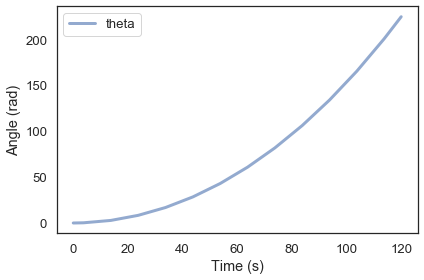

In [14]:
def plot_theta(results):
    plot(results.theta, color='C0', label='theta')
    decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')
    
plot_theta(results)

Plot `omega`

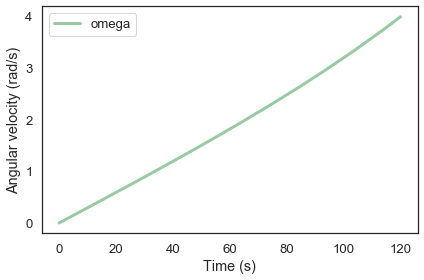

In [15]:
def plot_omega(results):
    plot(results.omega, color='C2', label='omega')

    decorate(xlabel='Time (s)',
             ylabel='Angular velocity (rad/s)')
    
plot_omega(results)

Plot `y`

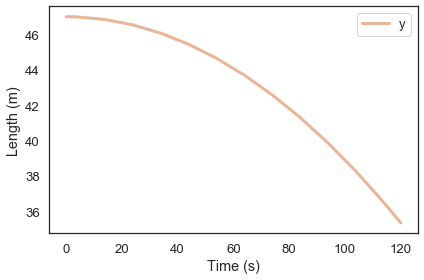

In [16]:
def plot_y(results):
    plot(results.y, color='C1', label='y')

    decorate(xlabel='Time (s)',
             ylabel='Length (m)')
    
plot_y(results)